In [1]:
from IPython import get_ipython
from IPython.display import display

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import torch

# Path to the saved checkpoint
checkpoint_path = '/content/drive/MyDrive/DR_GNN_Project/checkpoints/final_gat_gcn_model.pt'

# Load the checkpoint
checkpoint = torch.load(checkpoint_path)


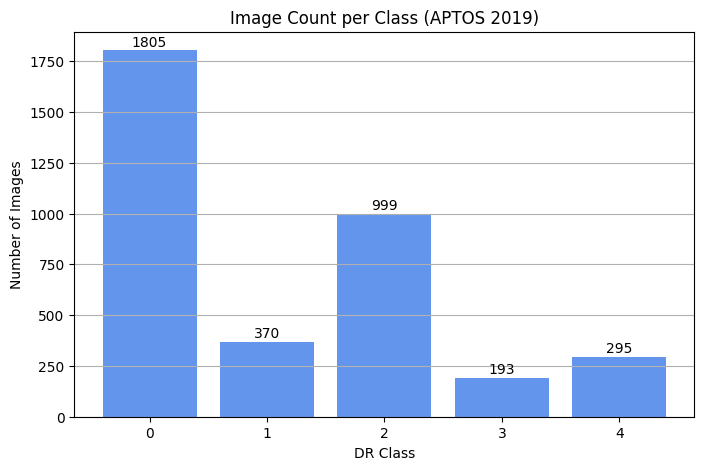

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

csv_path = '/content/drive/MyDrive/DR_GNN_Project/data/train.csv'

# Load the CSV
df = pd.read_csv(csv_path)
class_counts = df['diagnosis'].value_counts().sort_index()

# Plot
plt.figure(figsize=(8, 5))
bars = plt.bar(class_counts.index.astype(str), class_counts.values, color='cornflowerblue')
plt.xlabel('DR Class')
plt.ylabel('Number of Images')
plt.title('Image Count per Class (APTOS 2019)')
plt.grid(axis='y')

# Add counts on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 5, int(yval), ha='center', va='bottom')

plt.show()


In [5]:
!pip install torch_geometric

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision import models, transforms
from PIL import Image
import pandas as pd
import numpy as np
from torch_geometric.nn import GATConv, GCNConv, global_mean_pool
from torch_geometric.data import Data
from sklearn.neighbors import NearestNeighbors

import warnings
warnings.filterwarnings("ignore")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Dataset with ResNet + KNN Graph
class DRGraphDataset(Dataset):
    def __init__(self, csv_file, images_path, k=8, cache_features=False):
        # The constructor expects a csv_file path, not a DataFrame
        self.data = pd.read_csv(csv_file)
        self.images_path = images_path
        self.k = k
        self.cache_features = cache_features
        if self.cache_features and not os.path.exists("feature_cache"):
            os.makedirs("feature_cache")

        # Use pretrained ResNet18 (cut off after avgpool layer)
        backbone = models.resnet18(weights='IMAGENET1K_V1')
        self.feature_extractor = nn.Sequential(*list(backbone.children())[:-2])
        self.feature_extractor.to(device).eval()

        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.data)

    def extract_features(self, image_tensor, img_name):
        # Optional caching for faster reuse
        if self.cache_features:
            feat_path = os.path.join("feature_cache", f"{img_name}.pt")
            if os.path.exists(feat_path):
                return torch.load(feat_path)

        with torch.no_grad():
            feat_map = self.feature_extractor(image_tensor.unsqueeze(0).to(device))  # (1, 512, 7, 7)
            feat_map = feat_map.squeeze(0).permute(1, 2, 0).reshape(-1, 512)  # (49, 512)

        if self.cache_features:
            torch.save(feat_map.cpu(), feat_path)

        return feat_map.cpu()

    def build_knn_graph(self, features):
        knn = NearestNeighbors(n_neighbors=self.k + 1).fit(features)
        _, indices = knn.kneighbors(features)
        edges = []
        for i, neighbors in enumerate(indices):
            for j in neighbors[1:]:  # skip self
                edges.append([i, j])
        edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
        return edge_index

    def __getitem__(self, idx):
        img_name = self.data.iloc[idx, 0]
        label = int(self.data.iloc[idx, 1])
        img_path = os.path.join(self.images_path, img_name + ".png")

        try:
            image = self.transform(Image.open(img_path).convert("RGB"))
        except Exception as e:
            print(f"Error loading image: {img_path}, skipping...")
            # This recursive call can potentially lead to infinite loops if many images fail
            # Consider adding a counter or returning None and handling it in the DataLoader
            return self.__getitem__((idx + 1) % len(self))  # retry with next image

        features = self.extract_features(image, img_name)
        edge_index = self.build_knn_graph(features)

        graph = Data(x=features, edge_index=edge_index, y=torch.tensor(label))
        return graph


# 2. GNN Models
class GATModel(nn.Module):
    def __init__(self, in_channels=512, hidden_channels=64, out_channels=5):
        super(GATModel, self).__init__()
        self.gat1 = GATConv(in_channels, hidden_channels, heads=4, dropout=0.2)
        self.gat2 = GATConv(hidden_channels * 4, 32, heads=4, dropout=0.2)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(32 * 4, out_channels)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.gat1(x, edge_index))
        x = F.relu(self.gat2(x, edge_index))
        x = global_mean_pool(x, batch)
        x = self.dropout(x)
        return self.fc(x)


class GCNModel(nn.Module):
    def __init__(self, in_channels=512, hidden_channels=64, out_channels=5):
        super(GCNModel, self).__init__()
        self.gcn1 = GCNConv(in_channels, hidden_channels)
        self.gcn2 = GCNConv(hidden_channels, 64)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(64, out_channels)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.gcn1(x, edge_index))
        x = F.relu(self.gcn2(x, edge_index))
        x = global_mean_pool(x, batch)
        x = self.dropout(x)
        return self.fc(x)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.0 MB/s eta 0:00:00


In [6]:
import torch
import torch.nn as nn
import random
import pandas as pd
from torch_geometric.loader import DataLoader

# from your_module import DRGraphDataset, GATModel, GCNModel # These classes are defined in previous cells

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_model(csv_path, images_path, max_per_class=200, num_epochs=30, save_path="best_model.pth", early_stop=False):
    # Load full CSV once outside the loop
    df = pd.read_csv(csv_path)

    # Initialize models once
    gat = GATModel().to(device)
    gcn = GCNModel().to(device)

    optimizer = torch.optim.Adam(
        list(gat.parameters()) + list(gcn.parameters()), lr=1e-3, weight_decay=1e-4
    )
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
    criterion = nn.CrossEntropyLoss()

    best_loss = float('inf')
    patience = 5
    patience_counter = 0

    for epoch in range(num_epochs):
        # 🔁 Fresh random sample each epoch (stratified cap)
        # Note: The sampling is done here, but the DRGraphDataset as currently defined
        # re-loads the *full* CSV file every time it's instantiated.
        # To train on the sampled data, you would need to modify DRGraphDataset
        # to accept the DataFrame directly or write the sampled data to a temporary CSV.
        # Given the current DRGraphDataset implementation, passing csv_path is the correct way
        # to instantiate it according to its defined __init__ method signature.
        df_balanced = df.groupby('diagnosis').apply(
            lambda x: x.sample(n=min(len(x), max_per_class), random_state=random.randint(0, 10000))
        ).reset_index(drop=True)

        print(f"\nEpoch {epoch+1}/{num_epochs} - Sampled class distribution:")
        print(df_balanced['diagnosis'].value_counts())

        # --- FIX START ---
        # Pass csv_path to the DRGraphDataset constructor, as it expects a file path.
        # The 'df' keyword argument caused the TypeError because it's not in the constructor signature.
        dataset = DRGraphDataset(csv_file=csv_path, images_path=images_path)
        # --- FIX END ---

        loader = DataLoader(dataset, batch_size=8, shuffle=True)

        gat.train()
        gcn.train()
        total_loss = 0.0

        for data in loader:
            # Ensure data is not None in case __getitem__ skipped an image and returned None
            if data is None:
                continue # Skip this item

            data = data.to(device)
            optimizer.zero_grad()
            out1 = gat(data.x, data.edge_index, data.batch)
            out2 = gcn(data.x, data.edge_index, data.batch)
            out = (out1 + out2) / 2  # Ensemble
            loss = criterion(out, data.y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(loader)
        print(f"Loss: {avg_loss:.4f}")

        # Early stopping logic
        if avg_loss < best_loss:
            best_loss = avg_loss
            torch.save({'gat': gat.state_dict(), 'gcn': gcn.state_dict()}, save_path)
            patience_counter = 0
        else:
            patience_counter += 1
            if early_stop and patience_counter >= patience:
                print("Early stopping triggered.")
                break

        scheduler.step()

    # Load best model weights
    checkpoint = torch.load(save_path)
    gat.load_state_dict(checkpoint['gat'])
    gcn.load_state_dict(checkpoint['gcn'])

    return gat, gcn


In [7]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns
from tqdm import tqdm
import time
import random

from torch.utils.data import Subset
from torch_geometric.loader import DataLoader as GeoLoader

# Make sure this class is properly defined in your codebase
# from your_dataset_file import DRGraphDataset  # replace with actual file/module - This import is not needed as the class is defined in a previous cell

def evaluate_model(gat, gcn, csv_path, images_path, num_images=500, batch_size=8, k=8):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Time dataset creation
    start_time = time.time()
    # Instantiate DRGraphDataset using csv_path
    dataset = DRGraphDataset(csv_file=csv_path, images_path=images_path, k=k)

    indices = list(range(len(dataset)))
    random.shuffle(indices)
    test_subset = Subset(dataset, indices[:num_images])

    loader = GeoLoader(test_subset, batch_size=batch_size, shuffle=False)
    print(f"Dataset & Loader prepared in {time.time() - start_time:.2f}s")

    # Begin evaluation
    all_labels, all_probs, all_preds = [], [], []

    gat.eval()
    gcn.eval()

    with torch.no_grad():
        for data in tqdm(loader, desc="Evaluating"):
            # Ensure data is not None
            if data is None:
                continue # Skip this item

            data = data.to(device)
            out1 = gat(data.x, data.edge_index, data.batch)
            out2 = gcn(data.x, data.edge_index, data.batch)
            out = (out1 + out2) / 2

            probs = F.softmax(out, dim=1)
            preds = torch.argmax(out, dim=1)

            all_labels.extend(data.y.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    y_true = np.array(all_labels)
    y_pred = np.array(all_preds)
    y_probs = np.array(all_probs)

    # Handle case where no samples were processed
    if len(y_true) == 0:
        print("No samples processed for evaluation.")
        return 0.0

    unique_classes = np.unique(y_true)
    class_names = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR']
    # Filter class names to only include those present in the ground truth
    present_class_names = [class_names[i] for i in sorted(unique_classes)]

    print("\n📊 Classification Report:")
    # Use zero_division parameter to handle classes with no predicted samples
    print(classification_report(y_true, y_pred, labels=unique_classes, target_names=present_class_names, zero_division=0))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred, labels=unique_classes)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=present_class_names,
                yticklabels=present_class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # ROC Curve - Only plot if more than one class is present
    if len(unique_classes) > 1:
        y_true_bin = label_binarize(y_true, classes=np.arange(len(class_names))) # Binarize across all possible classes
        y_probs_filtered = y_probs # Use all columns of y_probs

        # Ensure y_true_bin and y_probs have the same number of samples
        if y_true_bin.shape[0] != y_probs_filtered.shape[0]:
             print("Mismatch between true labels and predicted probabilities shape. Skipping ROC.")
             # You might want to debug why this mismatch occurs if it happens frequently
        else:
            fpr, tpr, roc_auc = {}, {}, {}
            colors = ['blue', 'red', 'green', 'orange', 'purple']

            plt.figure(figsize=(10, 7))
            for i, class_name in enumerate(class_names): # Iterate through all possible class indices
                if i in unique_classes: # Only plot if the class is present in the ground truth
                     fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_probs_filtered[:, i])
                     roc_auc[i] = auc(fpr[i], tpr[i])
                     plt.plot(fpr[i], tpr[i], color=colors[i % len(colors)],
                              label=f'ROC {class_name} (AUC = {roc_auc[i]:.2f})')
                else:
                    # Optional: Add a note or handle classes not present
                    pass


            plt.plot([0, 1], [0, 1], 'k--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('ROC Curves')
            plt.legend(loc="lower right")
            plt.show()

            # Calculate Macro-average AUC only for classes present in y_true
            y_true_bin_present = label_binarize(y_true, classes=unique_classes)
            y_probs_present_cols = y_probs[:, unique_classes]

            if y_true_bin_present.shape[0] == y_probs_present_cols.shape[0]:
                 macro_auc = roc_auc_score(y_true_bin_present, y_probs_present_cols, average='macro')
                 print(f"\n🎯 Macro-average AUC (Present Classes): {macro_auc:.4f}")
            else:
                 print("Mismatch for Macro AUC calculation. Skipping.")


    accuracy = (y_true == y_pred).mean()
    print(f"\n✅ Overall Accuracy: {accuracy:.4f}")

    return accuracy

In [ ]:
csv_path = '/content/drive/MyDrive/DR_GNN_Project/data/train.csv'
images_path = '/content/drive/MyDrive/DR_GNN_Project/data/train_images'

# Call train_model with max_per_class=200 (or any other value you want)
gat_model, gcn_model = train_model(
    csv_path,
    images_path,
    max_per_class=200,    # cap of 200 images per class per epoch
    num_epochs=30
)


Epoch 1/30 - Sampled class distribution:
diagnosis
0    200
1    200
2    200
4    200
3    193
Name: count, dtype: int64


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 113MB/s]


Loss: 0.7789

Epoch 2/30 - Sampled class distribution:
diagnosis
0    200
1    200
2    200
4    200
3    193
Name: count, dtype: int64
Loss: 0.6199

Epoch 3/30 - Sampled class distribution:
diagnosis
0    200
1    200
2    200
4    200
3    193
Name: count, dtype: int64
Loss: 0.5707

Epoch 4/30 - Sampled class distribution:
diagnosis
0    200
1    200
2    200
4    200
3    193
Name: count, dtype: int64
Loss: 0.5235

Epoch 5/30 - Sampled class distribution:
diagnosis
0    200
1    200
2    200
4    200
3    193
Name: count, dtype: int64
Loss: 0.4862

Epoch 6/30 - Sampled class distribution:
diagnosis
0    200
1    200
2    200
4    200
3    193
Name: count, dtype: int64
Loss: 0.4559

Epoch 7/30 - Sampled class distribution:
diagnosis
0    200
1    200
2    200
4    200
3    193
Name: count, dtype: int64
Loss: 0.4334

Epoch 8/30 - Sampled class distribution:
diagnosis
0    200
1    200
2    200
4    200
3    193
Name: count, dtype: int64
Loss: 0.4144

Epoch 9/30 - Sampled class distrib

In [8]:
# Paths to your data
csv_path = '/content/drive/MyDrive/DR_GNN_Project/data/train.csv'
images_path = '/content/drive/MyDrive/DR_GNN_Project/data/train_images'

# Assuming you want to load models instead of training
# Comment out training and load models directly
# gat_model, gcn_model = train_model(csv_path, images_path, num_images=1500, num_epochs=25)

# Instead, define gat_model and gcn_model before loading state_dict
gat_model = GATModel().to(device) # Make sure device is set correctly
gcn_model = GCNModel().to(device) # Make sure device is set correctly

gat_model.load_state_dict(checkpoint['gat_model_state_dict'])
gcn_model.load_state_dict(checkpoint['gcn_model_state_dict'])

gat_model.eval()
gcn_model.eval()

GCNModel(
  (gcn1): GCNConv(512, 64)
  (gcn2): GCNConv(64, 64)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=64, out_features=5, bias=True)
)

Using device: cpu


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 55.5MB/s]


Dataset & Loader prepared in 1.50s


Evaluating: 100%|██████████| 150/150 [14:41<00:00,  5.88s/it]



📊 Classification Report:
                  precision    recall  f1-score   support

           No DR       0.98      0.97      0.98       588
            Mild       0.80      0.56      0.66       117
        Moderate       0.74      0.92      0.82       346
          Severe       0.70      0.46      0.55        50
Proliferative DR       0.77      0.56      0.65        99

        accuracy                           0.86      1200
       macro avg       0.80      0.69      0.73      1200
    weighted avg       0.86      0.86      0.86      1200



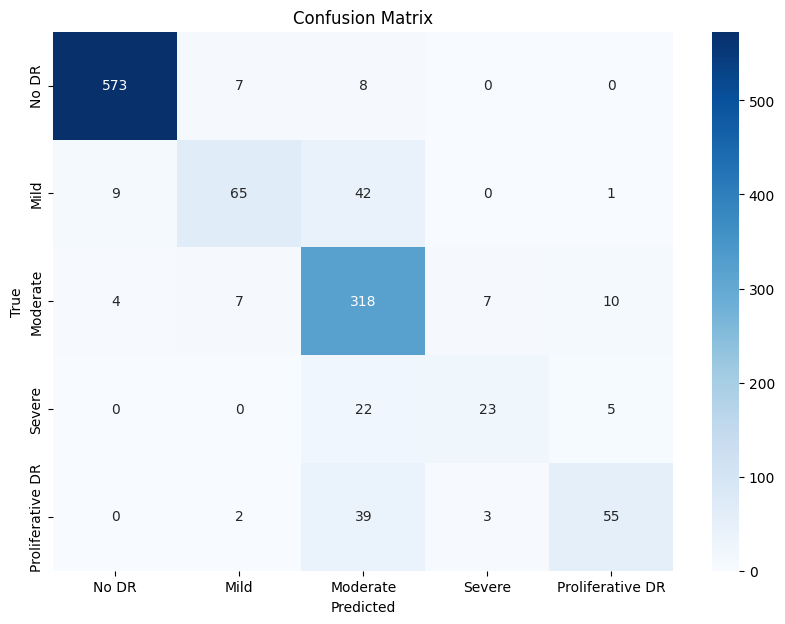

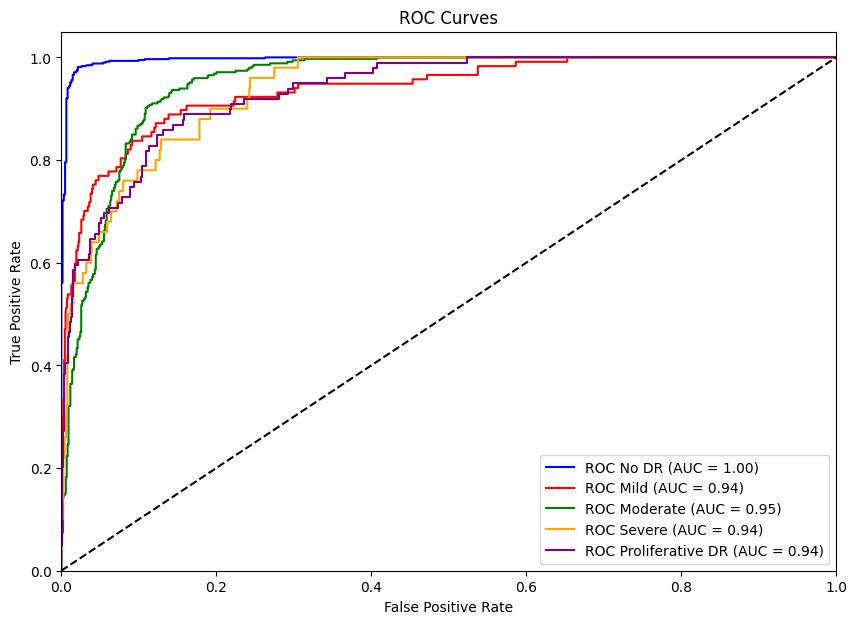


🎯 Macro-average AUC (Present Classes): 0.9523

✅ Overall Accuracy: 0.8617


In [9]:
import random
accuracy = evaluate_model(gat_model, gcn_model, csv_path, images_path, num_images=1200)

In [ ]:
!pip install gradio -q


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.9/322.9 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 99.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.5 MB/s eta 0:00:00


In [ ]:
from torchvision import models
import torch.nn as nn

# Load pretrained ResNet18 and remove the final layers
backbone = models.resnet18(weights='IMAGENET1K_V1')
feature_extractor = nn.Sequential(*list(backbone.children())[:-2])
feature_extractor.to(device).eval()


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [ ]:
import gradio as gr
from PIL import Image
import torch
from torch_geometric.data import Data
from torchvision import transforms, models
from sklearn.neighbors import NearestNeighbors
import torch.nn.functional as F

# Labels and stage explanations
labels = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR']
descriptions = {
    'No DR': "Healthy retina. No signs of diabetic retinopathy.",
    'Mild': "Early stage. Microaneurysms detected. Routine check-ups recommended.",
    'Moderate': "Noticeable microaneurysms and hemorrhages. Closer monitoring needed.",
    'Severe': "Numerous hemorrhages, venous beading. Pre-proliferative stage. Medical intervention necessary.",
    'Proliferative DR': "Advanced stage. Neovascularization present. Immediate treatment required."
}
explanations = {
    'No DR': "The model found no signs of microaneurysms, hemorrhages, or abnormal vessel growth—indicating a healthy retina.",
    'Mild': "The model detected tiny red dots—microaneurysms—which are the earliest visible signs of DR.",
    'Moderate': "Both microaneurysms and dot-blot hemorrhages were detected. These suggest capillary damage progressing across the retina.",
    'Severe': "Large areas of hemorrhaging and venous beading were identified. This suggests ischemia and impending neovascular changes.",
    'Proliferative DR': "Abnormal new blood vessels (neovascularization) were detected, typically a result of severe retinal ischemia. This is a critical stage requiring immediate care."
}

# Transform for preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained feature extractor (ResNet18 without final layers)
feature_extractor = models.resnet18(pretrained=True)
feature_extractor = torch.nn.Sequential(*list(feature_extractor.children())[:-2]).to(device)
feature_extractor.eval()

# Define and load GAT and GCN models
gat_model = GATModel().to(device)
gcn_model = GCNModel().to(device)

# Load trained weights
checkpoint = torch.load('/content/drive/MyDrive/DR_GNN_Project/checkpoints/final_gat_gcn_model.pt', map_location=device)
gat_model.load_state_dict(checkpoint['gat_model_state_dict'])
gcn_model.load_state_dict(checkpoint['gcn_model_state_dict'])

# Predict function with explainability
def predict_image(image):
    try:
        image = Image.fromarray((image * 255).astype('uint8')).convert("RGB")
        image_tensor = transform(image).unsqueeze(0).to(device)

        # Extract CNN features
        with torch.no_grad():
            features = feature_extractor(image_tensor)
            features = features.squeeze(0).permute(1, 2, 0).reshape(-1, 512)  # (49, 512)

        # Build KNN graph
        knn = NearestNeighbors(n_neighbors=9).fit(features.cpu().numpy())
        _, indices = knn.kneighbors(features.cpu().numpy())
        edges = []
        for i, neighbors in enumerate(indices):
            for j in neighbors[1:]:  # skip self
                edges.append([i, j])
        edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

        # Build graph
        graph = Data(x=features.cpu(), edge_index=edge_index)
        graph.batch = torch.zeros(graph.x.size(0), dtype=torch.long)

        with torch.no_grad():
            out_gat = gat_model(graph.x.to(device), graph.edge_index.to(device), graph.batch.to(device))
            out_gcn = gcn_model(graph.x.to(device), graph.edge_index.to(device), graph.batch.to(device))
            out = (out_gat + out_gcn) / 2
            pred = torch.argmax(F.softmax(out, dim=1), dim=1).item()

        stage = labels[pred]
        description = descriptions[stage]
        explanation = explanations[stage]

        report = f"""
        ### 🩺 Diabetic Retinopathy Report

        **Prediction**: **{stage}**

        **Severity Level**: {pred}

        **Explanation**:
        {explanation}

        **Medical Insight**:
        {description}
        """

        return report

    except Exception as e:
        return f"❌ Error: {str(e)}"

# Gradio interface
gr.Interface(
    fn=predict_image,
    inputs=gr.Image(type="numpy", label="Upload Retina Image (.png or .jpg)"),
    outputs="markdown",
    title="🧠 Diabetic Retinopathy Predictor",
    description="Upload a retina image to detect the DR stage using an explainable Graph Neural Network + ResNet18 pipeline.",
    theme="default"
).launch(debug=True)


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://02882ccdf97d8103c9.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
